In [14]:
import numpy as np
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units 
from metpy.interpolate import cross_section
from scipy import signal
from diagnosticSGfunctions import gkern as create_gaussian_kernel

import matplotlib
%matplotlib inline

In [15]:
# lon_start = 90.0
# lon_end = 125.0
# lat_start = 0.0
# lat_end = 15.0

lon_start = 104.0
lon_end = 115.0
lat_start = 5.5
lat_end = 7.0

In [16]:
time = int(48)-12
gl_pe='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe{0:03d}.nc'.format(time)
gl_pc='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pc{0:03d}.nc'.format(time)
gl_pb='/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pb{0:03d}.nc'.format(time)

input_data_pe = xr.open_dataset(gl_pe).metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                                        earth_radius=6371229.0)
input_data_pc = xr.open_dataset(gl_pc, drop_variables=['unspecified_5','unspecified_6',   # heating rate 
                                                       'unspecified_9','unspecified_10'])
input_data_pc = input_data_pc.metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                               earth_radius=6371229.0)
input_data_pb = xr.open_dataset(gl_pb).metpy.assign_crs(grid_mapping_name='latitude_longitude', 
                                                        earth_radius=6371229.0)

In [17]:
gdata_pe=input_data_pe.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end),
                                 longitude_1=slice(lon_start, lon_end), latitude_1=slice(lat_start, lat_end) )
gdata_pb=input_data_pb.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end) )
gdata_pc=input_data_pc.sel(longitude=slice(lon_start, lon_end), latitude=slice(lat_start, lat_end) )

In [18]:
heating_rate = 0
vars_list = ['unspecified', 'unspecified_1', 'unspecified_2', 'unspecified_3',
             'unspecified_4', 'unspecified_7','unspecified_8']
for var in vars_list:
    heating_rate = heating_rate + gdata_pc[var]

In [19]:
ht_coords = gdata_pe.u['hybrid_ht_1'].data.astype('int32')

u_gl = gdata_pe.u.interp(longitude_1=gdata_pe.v["longitude"],
                         hybrid_ht_1=ht_coords,
                         method="linear").assign_coords(height_levels=("hybrid_ht_1",
                        ht_coords)).swap_dims({"hybrid_ht_1":
                        "height_levels"})
v_gl = gdata_pe.v.interp(latitude_1=gdata_pe.u["latitude"],
                         hybrid_ht_1=ht_coords,
                         method="linear").assign_coords(height_levels=("hybrid_ht_1",
                        ht_coords)).swap_dims({"hybrid_ht_1":
                                               "height_levels"})
pv_gl = gdata_pe.field83.interp(hybrid_ht=ht_coords,
                                method="linear").assign_coords(height_levels=("hybrid_ht",
                                ht_coords)).swap_dims({"hybrid_ht":
                                                       "height_levels"})
w_gl  = gdata_pe.dz_dt.interp(hybrid_ht=ht_coords,
                              method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})

q_gl  = gdata_pb.q.interp(hybrid_ht=ht_coords,
                          method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})
th_gl = gdata_pb.theta.interp(hybrid_ht=ht_coords,
                              method="linear").assign_coords(height_levels=("hybrid_ht",
                            ht_coords)).swap_dims({"hybrid_ht":
                                                   "height_levels"})
rho_gl = gdata_pb.field27.interp(hybrid_ht_1=ht_coords,
                                 method="linear").assign_coords(height_levels=("hybrid_ht_1",
                                ht_coords)).swap_dims({"hybrid_ht_1":"height_levels"})
heating_rate = heating_rate.interp(hybrid_ht=ht_coords,
                                   method="linear").assign_coords(height_levels=("hybrid_ht",
                                ht_coords)).swap_dims({"hybrid_ht":"height_levels"})
exner_func = gdata_pb.field7.interp(hybrid_ht_1=ht_coords,
                                 method="linear").assign_coords(height_levels=("hybrid_ht_1",
                                ht_coords)).swap_dims({"hybrid_ht_1":"height_levels"})

In [20]:
u_gl = u_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
v_gl = v_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
w_gl = w_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

th_gl = th_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
q_gl = q_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
rho_gl = rho_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

vort_gl = mpcalc.vorticity(u_gl, v_gl, dx=None, dy=None)
abs_vort_gl = mpcalc.absolute_vorticity(u_gl, v_gl, dx=None, dy=None)

vort_gl = vort_gl.sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
abs_vort_gl = abs_vort_gl.sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))
heating_rate = heating_rate.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end)) / 3600.
exner_func = exner_func.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end))

## Calculate Ertel PV

In [21]:
# latitude = th_gl.latitude * (np.pi / 180.)
# f0 = 1.4584E-4 * np.sin(latitude)

# d_heating_rate_dz = mpcalc.first_derivative(heating_rate, axis=0)
# d_theta_dz = mpcalc.first_derivative(th_gl, axis=0)

# ertel_pv = (1 / rho_gl) * f0 * d_theta_dz

## START FROM HERE

- Read in Ertel PV from the global MetUM
- Compare with the value calculated above
- Should match the values we already see in Figure 13 (b) and (d)
- Input this into our wave phase speed calculation 

In [22]:
pv_gl = pv_gl.squeeze('t').sel(latitude=slice(lat_start,lat_end)).sel(longitude=slice(lon_start,lon_end)) * 1000000.

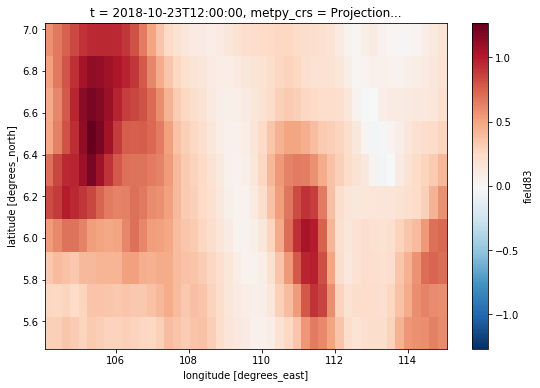

In [23]:
pv_gl.sel(height_levels=6000,method='nearest').plot(figsize=(9,6))

## Select height levels and plot Ertel PV

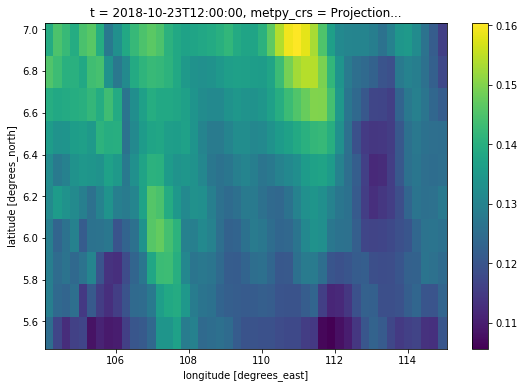

In [36]:
ertel_pv = ertel_pv.sel(height_levels=slice(0,15000))
ertel_pv_pvu = ertel_pv * 1000000
ertel_pv_pvu.sel(height_levels=6000, method='nearest').plot(figsize=(9,6))

## Upper wave phase speed calculation

### Calculate first term in Eq. 6 (absolute vorticity)

In [31]:
rho_upper = rho_gl.sel(height_levels=slice(8000,10000)).mean(dim=['height_levels'])
rho_lower = rho_gl.sel(height_levels=slice(2000,4000)).mean(dim=['height_levels'])
rho_ave = ( (rho_upper + rho_lower) / 2).mean() 

q_ave = q_gl.sel(height_levels=6000, method="nearest").mean()
abs_vort = abs_vort_gl.sel(height_levels=6000, method="nearest").mean()

th_upper = th_gl.sel(height_levels=slice(8000,10000)).mean(dim=['height_levels'])
th_lower = th_gl.sel(height_levels=slice(2000,4000)).mean(dim=['height_levels'])
d_theta  = (th_upper - th_lower).mean()
th_ref   = 300.0
dz       = 6000.0

# term_1 = (9.81 * d_theta / (rho_ave * q_ave * th_ref * dz) )
# term_1 = (abs_vort * d_theta / (rho_ave * dz) ) # Current value = 3.52 x 10-7
term_1 = (f0.mean() * d_theta / (rho_ave * dz) ) # Updated value = 1.10 x 10-7

### Calculate second term in Eq. 6 (moist stability)

In [33]:
# calculate moist stability
th_dz = mpcalc.first_derivative(th_gl, axis=0)
th_dz = th_dz * (9.81 / th_ref)
moist_stability = q_gl * th_dz

moist_stability_upper = moist_stability.sel(height_levels=slice(8000,
                            10000)).mean(dim=['height_levels']).mean()
moist_stability_lower = moist_stability.sel(height_levels=slice(2000,
                            4000)).mean(dim=['height_levels']).mean()
moist_stability_interface = moist_stability.sel(height_levels=6000, method='nearest').mean()

term_2 = (moist_stability_upper - moist_stability_lower) / moist_stability_interface # Current value = -2.49

moist_stratification_factor = term_1 * term_2 # Current value = -8.77 x 10-7 (seems much smaller than expected)

### Calculate third term in Eq. 6 (diabatic heating)

In [34]:
exner_func_6km = exner_func.sel(height_levels=6000, method="nearest").mean()
heating_rate_6km = (heating_rate.sel(height_levels=6000, method="nearest"))

# new method to calculate amplitude (smooth field, and calculate standard deviation)
kernel_2d = create_gaussian_kernel(3, 1.0)
heating_rate_smoothed = xr.DataArray(signal.convolve2d(heating_rate_6km, kernel_2d, boundary='symm', mode='same'))
heating_rate_mean = heating_rate_smoothed.mean()
heating_rate_std = (heating_rate_smoothed - heating_rate_mean).std()
heating_rate_amplitude = (heating_rate_6km.max() - heating_rate_6km.min()) / 2

# ertel PV (new)
ertel_pv_6km = ertel_pv.sel(height_levels=6000, method='nearest')
ertel_pv_smoothed = xr.DataArray(signal.convolve2d(ertel_pv_6km, kernel_2d, boundary='symm', mode='same'))
ertel_pv_mean = ertel_pv_smoothed.mean()
ertel_pv_std = (ertel_pv_smoothed - ertel_pv_mean).std()
ertel_pv_amplitude = (ertel_pv_6km.max() - ertel_pv_6km.min()) / 2

pv_wave_length = 8.0 * 111000 
pv_wave_number = (2 * np.pi) / pv_wave_length

term_3a = 1 / pv_wave_number
term_3b = heating_rate_std / d_theta 

term_3c = 1 / ertel_pv_std

term_3 = (term_3a * term_3b * term_3c).mean()

upper_wave_phase_speed = moist_stratification_factor * term_3

In [43]:
upper_wave_phase_speed

<xarray.DataArray ()>
<Quantity(-6.825324471472166, 'dimensionless')>
Coordinates:
    t              datetime64[ns] 2018-10-23T12:00:00
    metpy_crs      object Projection: latitude_longitude
    hybrid_ht      int32 6196
    height_levels  int32 6196

## Lower wave phase speed calculation

In [17]:
th_lower = th_gl.sel(height_levels=1400, method="nearest")

In [18]:
gdata_pb_theta = input_data_pb.sel(longitude=slice(104.0, 115.0), latitude=slice(5.5, 9.0) )

th_lower = gdata_pb_theta.theta.interp(hybrid_ht=ht_coords,
                                     method="linear").assign_coords(height_levels=("hybrid_ht",
                                    ht_coords)).swap_dims({"hybrid_ht":"height_levels"})

In [19]:
th_lower = th_lower.squeeze('t').sel(height_levels=1400, method="nearest")

In [20]:
th_ave_north = th_lower.sel(latitude=9.0, method="nearest").mean()
th_ave_south = th_lower.sel(latitude=5.5, method="nearest").mean()

In [21]:
th_dy = (th_ave_north - th_ave_south) / (3.5 * 111000)

In [22]:
## Lower-level wave (theta) ### 

theta_wave_length = 8.0 * 111000
theta_wave_number = (2 * np.pi) / theta_wave_length

theta_smoothed = xr.DataArray(signal.convolve2d(th_lower, kernel_2d, boundary='symm', mode='same'))
theta_mean = theta_smoothed.mean()
theta_std = (theta_smoothed - theta_mean).std()

v_lower = v_gl.sel(height_levels=1400, method="nearest")
v_smoothed = xr.DataArray(signal.convolve2d(v_lower, kernel_2d, boundary='symm', mode='same'))
v_mean = v_smoothed.mean()
v_std = (v_smoothed - v_mean).std()

base_state_gradient = - ( (1 / theta_wave_number) * (th_dy / d_theta) )
wave_amplitude = d_theta / theta_std
frequency = theta_wave_number * v_std
length_scale = 1 / theta_wave_number
lower_wave_phase_speed = base_state_gradient * wave_amplitude * frequency * length_scale

In [23]:
upper_wave_phase_speed, lower_wave_phase_speed

(<xarray.DataArray ()>
 <Quantity(-228414.16588231464, '1 / second')>
 Coordinates:
     t              datetime64[ns] 2018-10-23T12:00:00
     metpy_crs      object Projection: latitude_longitude
     hybrid_ht_1    int32 6196
     height_levels  int32 6196
     hybrid_ht      int32 6196,
 <xarray.DataArray ()>
 array(-1.5810024)
 Coordinates:
     t              datetime64[ns] 2018-10-23T12:00:00
     metpy_crs      object Projection: latitude_longitude
     hybrid_ht      int32 1396
     height_levels  int32 1396)

In [24]:
# U1 = u_gl.sel(height_levels=1400, method="nearest").mean()
# U2 = u_gl.sel(height_levels=6000, method="nearest").mean()